# 1. Context:
The American Stroke Association [reports](https://www.stroke.org/en/about-stroke), "stroke is the no. 5 cause of death and a leading cause of disability in the United States". In addition, according to [the Center for Disease Control and Prevention (CDC)](https://www.cdc.gov/stroke/conditions.htm), the factors that lead to an increased chance of stroke include high blood pressure, high cholesterol, high blood glucose level, etc. These conditions are further enhanced by an unhealthy diet, physical inactivity, and alcohol and tobacco use (including smoking). 

The available dataset can be used to predict whether a patient is likely to get a stroke based on other features and behaviors like age, gender, smoking status, blood sugar level, etc.

### Attribute Information

1) id: unique identifier

2) gender: "Male", "Female" or "Other"

3) age: age of the patient

4) hypertension: 0 if the patient doesn't have hypertension, 1 if the patient has hypertension

5) heart_disease: 0 if the patient doesn't have any heart diseases, 1 if the patient has a heart disease

6) ever_married: "No" or "Yes"

7) work_type: "children", "Govt_jov", "Never_worked", "Private" or "Self-employed"

8) Residence_type: "Rural" or "Urban"

9) avg_glucose_level: average glucose level in blood

10) bmi: body mass index

11) smoking_status: "formerly smoked", "never smoked", "smokes" or "Unknown"*

12) stroke: 1 if the patient had a stroke or 0 if not

**Note:** _"Unknown" in smoking_status means that the information is unavailable for this patient._


# 2. Importing the necessary modules:

In [1]:
# Import the required modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

ModuleNotFoundError: No module named 'imblearn'

# 3. Data Loading and Exploration:

In [2]:
# Load the data as a dataframe
data = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
data.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 3.1 Data Exploration

In this section, we will do some data exploration using pandas, including looking at the missing values and the data types. Any inconsistencies need to be dealt with using data cleaning processes.

In [3]:
print(data.dtypes)
print("===================================================================")
print(data.describe())

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object
                 id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  

All data types seem to be correct. There are some missing values in the `bmi` column, but the others seem to be okay in that front. Most of the `object` type columns seem to be categorical with number of distinct values ranging from 2 to 5. Let's take a deeper look into the dataset, focusing on the categorical variables with less than or equal to 5 categories.

In [4]:
# Print the column names and the number of unique values
# if the number of unique values is less than or equal to 5
col_names = data.columns
col_nunique = []
col_unique = []
for column in data.columns:
    col_nunique.append(data[column].nunique())
    col_unique.append(data[column].unique())
    
features = pd.DataFrame({'Feature':col_names, 'Number of Categories': col_nunique, 'Categories': col_unique})
features = features[features['Number of Categories']<=5]
features

,Feature,Number of Categories,Categories
1,gender,3,"[Male, Female, Other]"
3,hypertension,2,"[0, 1]"
4,heart_disease,2,"[1, 0]"
5,ever_married,2,"[Yes, No]"
6,work_type,5,"[Private, Self-employed, Govt_job, children, N..."
7,Residence_type,2,"[Urban, Rural]"
10,smoking_status,4,"[formerly smoked, never smoked, smokes, Unknown]"
11,stroke,2,"[1, 0]"


The `gender` column seems to have 3 values - male, female and 'other'. The 'other' category was probably due to lack of information. According to a [publication](https://pubmed.ncbi.nlm.nih.gov/11252851/) from the National Institutes of Health (NIH), "the prevalence of stroke is higher among men up to the age of approximately 80 years, after which it becomes higher in women." This clearly indicates a dependence of stroke on gender. Therefore, the 'other' values in the gender column must be taken care of. This can either be by imputation or by removing the rows, depending on how many rows there are. We will deal with these categories in a later section, along with encoding the categorical variables for better classification.

But before that, let's check out the missing values.

In [5]:
# Find the missing values
data.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

The column `bmi` has 201 missing values while none of the other columns have any. From the description of the dataset earlier, we saw that while the other data columns have values in the acceptable ranges, the column `bmi` seems off. The Body Mass Index (BMI) of regular humans ranges from 30.0 to 39.9 for "obese" body type. A bmi of 97.6 seems like an outlier data point. Let's take a closer look at this column.

In [6]:
# check for all the data above normal ranges
data[data['bmi']>40]

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
21,13861,Female,52.0,1,0,Yes,Self-employed,Urban,233.29,48.9,never smoked,1
30,43717,Male,57.0,1,0,Yes,Private,Urban,212.08,44.2,smokes,1
60,10710,Female,56.0,0,0,Yes,Private,Urban,185.17,40.4,formerly smoked,1
66,17004,Female,70.0,0,0,Yes,Private,Urban,221.58,47.5,never smoked,1
79,42117,Male,43.0,0,0,Yes,Self-employed,Urban,143.43,45.9,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5056,53478,Female,40.0,0,0,Yes,Private,Urban,89.61,41.2,formerly smoked,0
5057,38349,Female,49.0,0,0,Yes,Govt_job,Urban,69.92,47.6,never smoked,0
5081,37680,Male,55.0,0,0,Yes,Govt_job,Rural,108.35,40.8,formerly smoked,0
5097,64520,Male,68.0,0,0,Yes,Self-employed,Urban,91.68,40.8,Unknown,0


There seem to be a lof of people (408 to be exact) with their BMI higher than 40. A person with a BMI of over 40 is considered to be "morbidly obese" according to a study by the [University of Rochester](https://www.urmc.rochester.edu/highland/bariatric-surgery-center/journey/morbid-obesity.aspx#:~:text=Normal%20BMI%20ranges%20from%2020,high%20blood%20pressure%20or%20diabetes.).

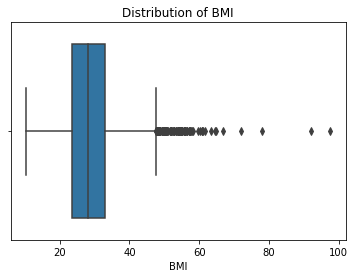

In [7]:
# Determine the outliers in the bmi column
# Plot a boxplot
sns.boxplot(data['bmi'], orient='v')
plt.title('Distribution of BMI')
plt.xlabel('BMI')
plt.show()

Clearly, there are a lot of outliers in the dataset. The BMI, if above 40, is directly related to high blood sugar levels. Let's see if Pearson's correlation matches this fact.

In [8]:
# Find correlation between BMI greater than 40 and average glucose level.
data[data['bmi']>40][['bmi', 'avg_glucose_level']].corr()

,bmi,avg_glucose_level
bmi,1.000000,-0.031528
avg_glucose_level,-0.031528,1.000000


The Pearson's correlation coefficient doesn't approve of a direct relation between `bmi` and `avg_glucose_level`, which is very odd. In fact, the coefficient suggests that they are almost unrelated (the coefficient is very close to 0). Let's look at the distribution of the BMI to see what values might be ignored (if we may).

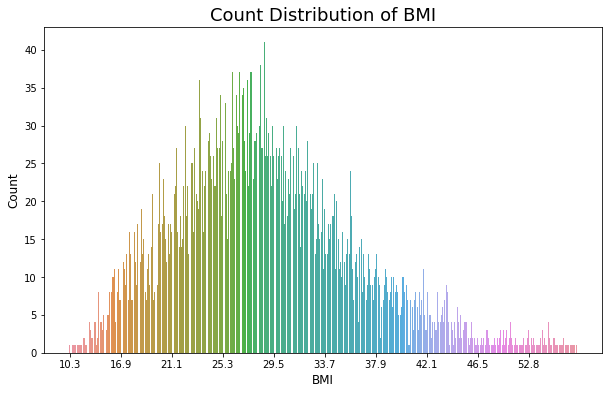

In [9]:
# Plot a bar graph for the BMI data to get a closer look
plt.figure(figsize=(10,6))
sns.countplot(data['bmi'])
plt.locator_params(axis='x', nbins=10)
plt.title('Count Distribution of BMI', fontsize=18)
plt.xlabel('BMI', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.show();

There is a long tail in the data after the BMI of around 46.5. This can be considered the cutoff for the BMI. But before that, we will impute the mean BMI value for the missing values.

# Feature Engineering

Let's impute the mean value of the BMI at all the missing data points.

#### 1. Impute the missing values:

In [10]:
# Impute the missing values
data['bmi'].fillna(data['bmi'].mean(), inplace=True)
data.isnull().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

#### 2. Replace the 'Other' value in gender with the most frequent value

In [11]:
# Replace 'other' with most frequent gender
df = data.copy()
df['gender'].replace('Other', data['gender'].value_counts().idxmax(), inplace=True)
df['gender'].unique()

array(['Male', 'Female'], dtype=object)

#### 3. Reduce the dataframe with bmi values less than 46.5

In [12]:
# Neglect the bmi values over 46.5
df = df[df['bmi']<=46.5]
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000,4989.000000
mean,36616.992584,43.191421,0.095610,0.055121,105.722283,28.295378,0.049308
std,21144.110153,22.784470,0.294086,0.228240,44.816024,6.652017,0.216533
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17827.000000,25.000000,0.000000,0.000000,77.190000,23.600000,0.000000
50%,37025.000000,45.000000,0.000000,0.000000,91.820000,28.200000,0.000000
75%,54795.000000,61.000000,0.000000,0.000000,113.800000,32.300000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,46.500000,1.000000


#### 4. Drop the unnecessary columns:

In [13]:
df.drop('id', axis=1, inplace=True)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


#### 5. Encode all the categorical columns:

In [14]:
# Select and transform the required columns
le = LabelEncoder()
cat_cols = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
df[cat_cols] = df[cat_cols].apply(le.fit_transform)
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1,67.0,0,1,1,2,1,228.69,36.600000,1,1
1,0,61.0,0,0,1,3,0,202.21,28.893237,2,1
2,1,80.0,0,1,1,2,0,105.92,32.500000,2,1
3,0,49.0,0,0,1,2,1,171.23,34.400000,3,1
4,0,79.0,1,0,1,3,0,174.12,24.000000,2,1


#### 6. Find the correlation coefficients between the columns:

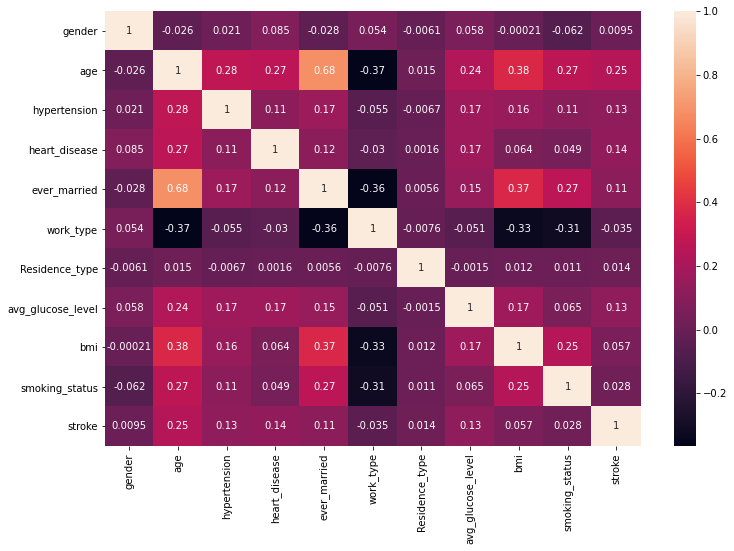

In [15]:
# Find the correlation matrix
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(), annot=True)
plt.show()

# Classification Model

In [16]:
# Perform the split into training and testing datasets
X = df.drop('stroke', axis=1)
y = df['stroke']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

#### 1. Logistic Regression

In [17]:
# Fit the model and Predict with Logistic Regression
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# Print out the metrics for Logistic Regression
print("The F1-score of Logistic Regression is: {}".format(round(f1_score(y_test, y_pred_lr),2)))
print("The ROC-AUC score of Logistic Regression is: {}".format(roc_auc_score(y_test, y_pred_lr),2))

The F1-score of Logistic Regression is: 0.0
The ROC-AUC score of Logistic Regression is: 0.5


#### 2. Decision Tree Classifier

In [18]:
# Fit the model and predict with Decision Tree Classifier
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

# Print out the metrics for Decision Tree Classifier
print("The F1-score of Decision Tree Classifier is: {}".format(round(f1_score(y_test, y_pred_dt),2)))
print("The ROC-AUC score of Decision Tree Classifier is: {}".format(round(roc_auc_score(y_test, y_pred_dt),2)))

The F1-score of Decision Tree Classifier is: 0.19
The ROC-AUC score of Decision Tree Classifier is: 0.58


#### 3. Random Forest Classifier

In [19]:
# Fit the model and predict with Random Forest Classifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

# Print out the metrics for Random Forest Classifier
print("The F1-score of Random Forest Classifier is: {}".format(round(f1_score(y_test, y_pred_rf),2)))
print("The ROC-AUC score of Random Forest Classifier is: {}".format(round(roc_auc_score(y_test, y_pred_rf),2)))

The F1-score of Random Forest Classifier is: 0.1
The ROC-AUC score of Random Forest Classifier is: 0.53


For the above classification models, it looks like the F1-score and the ROC/AUC score are really bad, except for the Decision Tree Classifier, where the numbers are slightly better. This can be because the ratio of "negative" to "positive" cases of strokes in the dataset is very, very high. Therefore, the model has high accuracy score in training the data but doesn't work very well with the testing dataset. Is there a way around this problem?

The low f1 scores and ROC-AUC scores are because of the mismatch in the number of target values. A popular method to deal with such a problem is resampling. The resampling can either be **undersampling**, which involves removing samples from the majority class and **oversampling**, where we add more examples from the minority class.

Each sampling method has it's own disadvantages in addition to the obvious advantages. In undersampling, where we only take samples from the majority class, there can be loss of important data. During oversampling, there will be copies of the minority class, which can cause overfitting.

**We will try both over-sampling and under-sampling to see if our model improves.**

# Resampling
**1. UNDER-SAMPLING:** 
We will use Python's imbalanced-learn module to under-sample our data.

In [20]:
# Use RandomUnderSampler module
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

# Use the resampled data to train the Decision Tree model:
dt_rus = DecisionTreeClassifier(random_state=0)
dt_rus.fit(X_rus, y_rus)
y_pred_dt_rus = dt_rus.predict(X_test)

# Print out the metrics for Decision Tree Classifier
print("The F1-score of Decision Tree Classifier is: {}".format(round(f1_score(y_test, y_pred_dt_rus),2)))
print("The ROC-AUC score of Decision Tree Classifier is: {}".format(round(roc_auc_score(y_test, y_pred_dt_rus),2)))

print("\n========================================================================================================\n")

# Use the resampled data to train the Logistic Regression model:
lr_rus = LogisticRegression(random_state=0)
lr_rus.fit(X_rus, y_rus)
y_pred_lr_rus = lr_rus.predict(X_test)

# Print out the metrics for Logistic Regression
print("The F1-score of Logistic Regression is: {}".format(round(f1_score(y_test, y_pred_lr_rus),2)))
print("The ROC-AUC score of Logistic Regression is: {}".format(round(roc_auc_score(y_test, y_pred_lr_rus),2)))

print("\n========================================================================================================\n")

# Check with Random Forest Classifier
rf_rus = RandomForestClassifier(random_state=0)
rf_rus.fit(X_rus, y_rus)
y_pred_rf_rus = rf_rus.predict(X_test)

# Print out the metrics for Random Forest Classifier
print("The F1-score of Random Forest Classifier is: {}".format(round(f1_score(y_test, y_pred_rf_rus),2)))
print("The ROC-AUC score of Random Forest Classifier is: {}".format(round(roc_auc_score(y_test, y_pred_rf_rus),2)))

The F1-score of Decision Tree Classifier is: 0.19
The ROC-AUC score of Decision Tree Classifier is: 0.73


The F1-score of Logistic Regression is: 0.23
The ROC-AUC score of Logistic Regression is: 0.78


The F1-score of Random Forest Classifier is: 0.22
The ROC-AUC score of Random Forest Classifier is: 0.77


**2. OVER-SAMPLING:**

In [21]:
# Use RandomOverSampler module
ros = RandomOverSampler(random_state=0)
X_ros, y_ros = ros.fit_resample(X_train, y_train)

# Use the resampled data to train the Decision Tree model:
dt_ros = DecisionTreeClassifier(random_state=0)
dt_ros.fit(X_ros, y_ros)
y_pred_dt_ros = dt_ros.predict(X_test)

# Print out the metrics for Decision Tree Classifier
print("The F1-score of Decision Tree Classifier is: {}".format(round(f1_score(y_test, y_pred_dt_ros),2)))
print("The ROC-AUC score of Decision Tree Classifier is: {}".format(round(roc_auc_score(y_test, y_pred_dt_ros),2)))

print("\n==========================================================================================\n")

# Check with Logistic Regression
lr_ros = LogisticRegression(random_state=0)
lr_ros.fit(X_ros, y_ros)
y_pred_lr_ros = lr_ros.predict(X_test)

# Print out the metrics for Logistic Regression
print("The F1-score of Logistic Regression is: {}".format(round(f1_score(y_test, y_pred_lr_ros),2)))
print("The ROC-AUC score of Logistic Regression is: {}".format(round(roc_auc_score(y_test, y_pred_lr_ros),2)))

print("\n==========================================================================================\n")

# Check with Random Forest Classifier
rf_ros = RandomForestClassifier(random_state=0)
rf_ros.fit(X_ros, y_ros)
y_pred_rf_ros = rf_ros.predict(X_test)

# Print out the metrics for Random Forest Classifier

print("The F1-score of Random Forest Classifier is: {}".format(round(f1_score(y_test, y_pred_rf_ros),2)))
print("The ROC-AUC score of Random Forest Classifier is: {}".format(round(roc_auc_score(y_test, y_pred_rf_ros),2)))

The F1-score of Decision Tree Classifier is: 0.14
The ROC-AUC score of Decision Tree Classifier is: 0.55


The F1-score of Logistic Regression is: 0.23
The ROC-AUC score of Logistic Regression is: 0.78


The F1-score of Random Forest Classifier is: 0.11
The ROC-AUC score of Random Forest Classifier is: 0.53


**Modeling the data using Logistic Regression and under/over-sampling gives the best results for this dataset.** The values of F-1 score and ROC-AUC score from both undersampling and oversampling for Logistic Regression are really close to each other. It is up to the user to look at the benefits and drawbacks of each method and decide which sampling method they want to follow. 